In [108]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm,gaussian_kde

In [32]:
data = pd.concat([pd.read_csv('./../data/%d.csv' % year) for year in range(2003,2017)])

In [5]:
rdata = pd.read_csv('./../data/round.csv')

In [6]:
rdata.head(2)

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694


In [7]:
data.head(2)

,Year,Tourn.#,Player_#,Course_#,Permanent_Tournament_#,Player_First_Name,Player_Last_Name,Round,Tournament_Name,Course_Name,...,Went_to_X,Went_to_Y,Went_to_Z,Started_at_X,Started_at_Y,Started_at_Z,Distance_from_hole,Cat,Green_to_work_with,Difficulty_Start
0,2003,440,20593,538,47,Greg,Chalmers,5,Las Vegas Invitational,TPC Summerlin,...,-398.204081,-104.551714,4.269,-1269.931111,-429.453390,NaN,1340.580188,Tee Box,37.363389,4.215190
1,2003,70,6515,500,7,Shaun,Micheel,1,Nissan Open,Riviera CC,...,-316.155150,-378.347489,-14.323,-639.244982,-1131.828038,NaN,1299.872631,Tee Box,21.707906,4.457746


In [10]:
with open('./../PickleFiles/hole_tups.pkl','r') as pickleFile:
    tournorder = pickle.load(pickleFile)

In [36]:
df = pd.DataFrame(tournorder)
df.columns = ['Year','Permanent_Tournament_#','Round','Course_#','Hole']
round_tups = df[['Year','Course_#','Round']].drop_duplicates().values.tolist()
round_tups = [tuple(tup) for tup in round_tups]

In [38]:
round_tups[0:5]

[(2003, 656, 1), (2003, 656, 2), (2003, 656, 3), (2003, 656, 4), (2003, 6, 2)]

In [33]:
def make_specific_cats(distance,cat,par):
    if cat=='Tee Box':
        if par==3:
            return 'Tee-3'
        else:
            return 'Tee-45'
    elif cat=='Bunker' or cat=='Other':
        return cat
    elif cat=='Green' or cat=='Fringe':
        if distance<5:
            return 'Green-0'
        elif distance<10:
            return 'Green-5'
        elif distance<20:
            return 'Green-10'
        else:
            return 'Green-20'
    elif cat=='Fairway':
        if distance<300:
            return 'Fairway-0'
        elif distance<540:
            return 'Fairway-300'
        else:
            return 'Fairway-540'
    elif cat=='Primary Rough' or cat=='Intermediate Rough':
        if distance<90:
            return 'Rough-0'
        elif distance<375:
            return 'Rough-90'
        else:
            return 'Rough-375'

In [34]:
data.insert(len(data.columns),'Specific_Cat',
            [make_specific_cats(tup[0],tup[1],tup[2]) 
             for tup in data[['Distance_from_hole','Cat','Par_Value']].values.tolist()])

In [35]:
data.Specific_Cat.value_counts()

Green-0        2818013
Tee-45         2781546
Green-20       1358330
Fairway-300    1145044
Green-10       1035734
Green-5         874724
Tee-3           823746
Rough-375       695727
Fairway-540     641033
Fairway-0       602925
Bunker          503585
Rough-0         480052
Rough-90        262059
Other            68023
Name: Specific_Cat, dtype: int64

First a baseline of SG to field using simple average SG on different categories of shots.

In [180]:
course_profiles = defaultdict(lambda: defaultdict(list))
for year,course,round in round_tups:
    day = data[(data.Year==year) & (data['Course_#']==course) & (data.Round==round)]
    cat_aves = {}
    for cat,df in day.groupby('Specific_Cat'):
        player_map = df.groupby('Player_#').Strokes_Gained.mean().to_dict()
        cat_aves[cat] = np.array([player_map[player] if player in player_map else 0.0 
                                  for player in pd.unique(day['Player_#'])])
    rday = rdata[(rdata.Tournament_Year==year) & (rdata['Course_#']==course) & (rdata.Round_Number==round)]
    if len(rday)==0:
        continue
    ave_score = rday.groupby('Player_Number').Round_Score.mean().mean()
    score_map = rday.groupby('Player_Number').Round_Score.mean().to_dict()
    score_vec = np.array([score_map[player]-ave_score if player in score_map else np.nan 
                          for player in pd.unique(day['Player_#'])])
    for cat in cat_aves:
        cat_aves[cat] = cat_aves[cat][~np.isnan(score_vec)]
        course_profiles[course][cat].append(np.corrcoef(score_vec[~np.isnan(score_vec)],cat_aves[cat])[0,1])

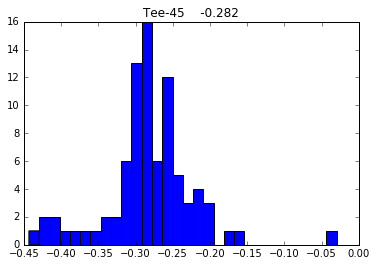

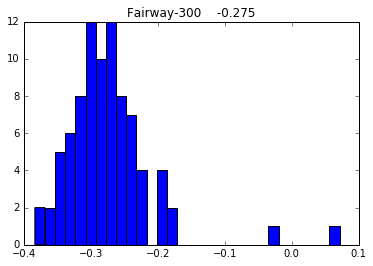

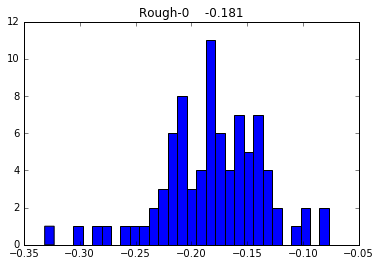

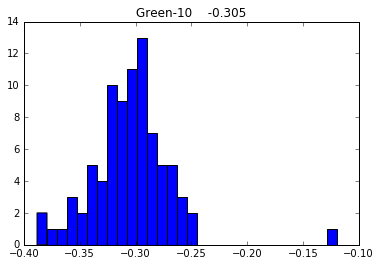

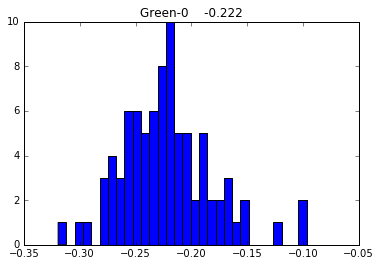

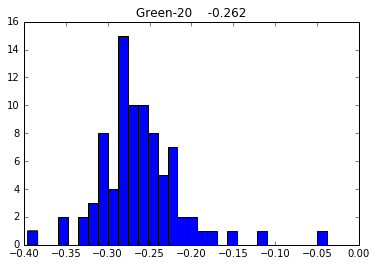

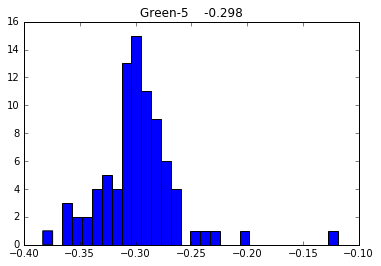

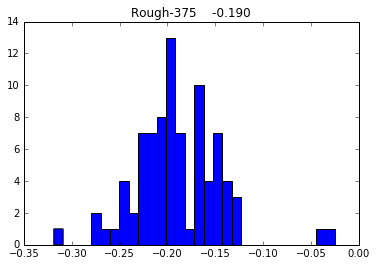

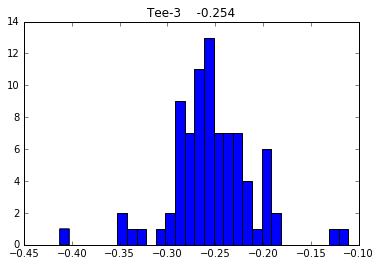

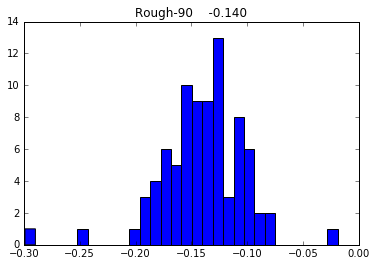

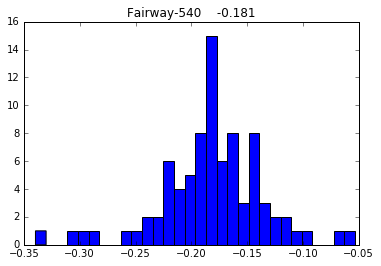

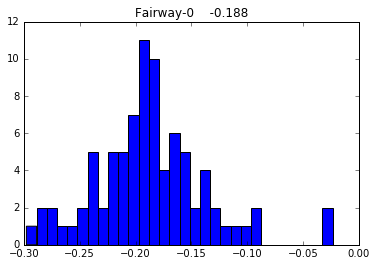

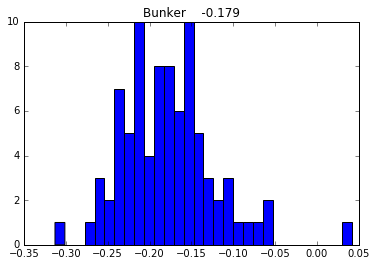

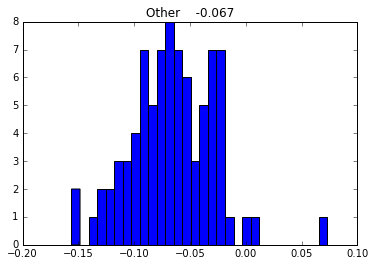

In [89]:
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    plt.hist(x,bins=30)
    plt.title(cat+'    %.3f' % np.mean(x))
    plt.show()

Set Priors

In [181]:
priors = defaultdict(None)
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    priors[cat] = (np.mean(x),np.std(x))

In [182]:
priors

defaultdict(None,
            {'Bunker': (-0.17868192820201398, 0.054583093382254082),
             'Fairway-0': (-0.1878019265399444, 0.050024037715439978),
             'Fairway-300': (-0.27510243101069115, 0.063826256700234424),
             'Fairway-540': (-0.1812335038661016, 0.046379149124701459),
             'Green-0': (-0.22243774662991139, 0.040959764404430811),
             'Green-10': (-0.30462705241605181, 0.03596912406023732),
             'Green-20': (-0.26198746827678382, 0.049154840357248382),
             'Green-5': (-0.29843758583081231, 0.035245620258273748),
             'Other': (-0.066538359253140292, 0.037729829283349843),
             'Rough-0': (-0.18099282335107106, 0.046414060071539032),
             'Rough-375': (-0.18993939363017701, 0.044368364992972704),
             'Rough-90': (-0.13986564123093118, 0.037930714775376781),
             'Tee-3': (-0.25363228069563298, 0.043798121504144097),
             'Tee-45': (-0.28220087042065922, 0.0602895334030488

In [183]:
for cat in pd.unique(data.Specific_Cat):
    mean,std = priors[cat][0],priors[cat][1]
    priors[cat] = [np.linspace(mean-3*std,mean+3*std,100),
                   norm.pdf(np.linspace(mean-3*std,mean+3*std,100),mean,std)/
                    norm.pdf(np.linspace(mean-3*std,mean+3*std,100),mean,std).sum()]

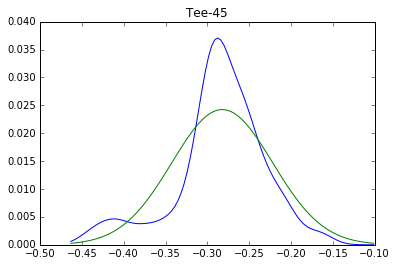

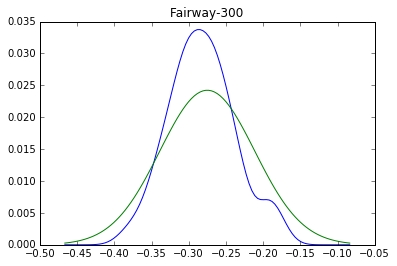

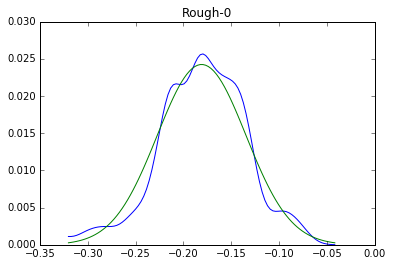

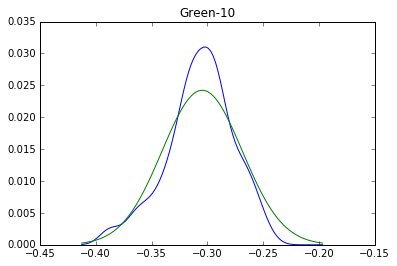

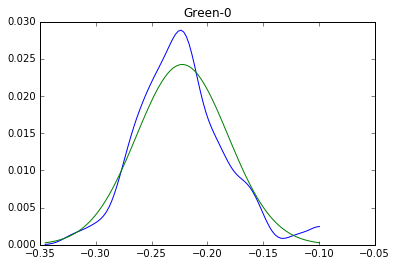

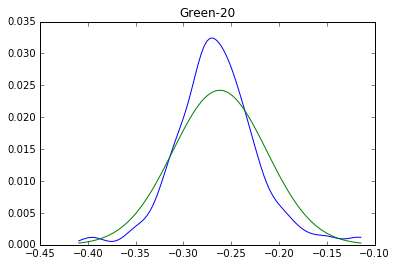

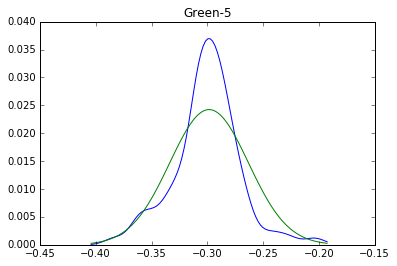

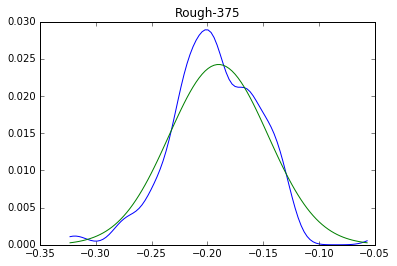

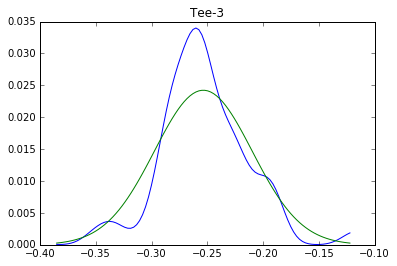

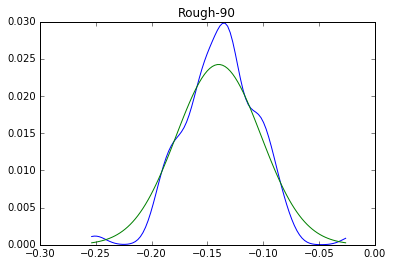

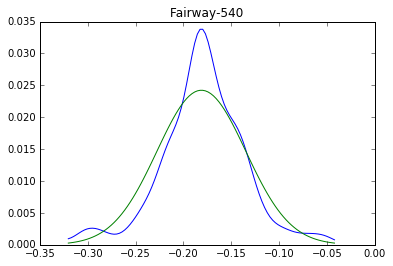

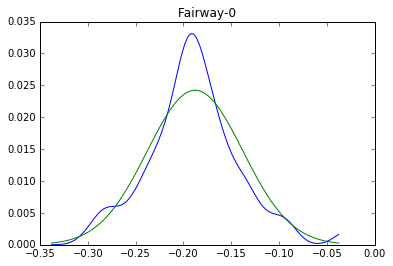

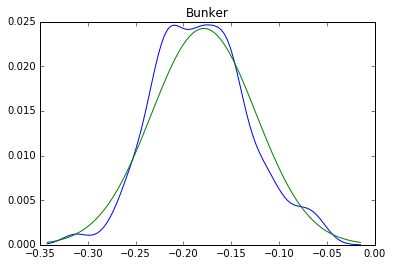

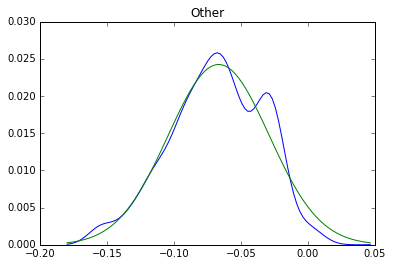

In [184]:
num_courses = len(pd.unique(data['Course_#']))
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    density = gaussian_kde(x)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(priors[cat][0],density(priors[cat][0])/density(priors[cat][0]).sum())
    plt.plot(priors[cat][0],priors[cat][1])
    plt.title(cat)
    plt.show()

Update based on data for each course, estimate posteriors

In [189]:
def update(x,p_x,r,n):
    se = 1.06/(n-3.0)**.5
    p_x *= norm.pdf(np.arctanh(x)-np.arctanh(r),0,se)
    p_x /= p_x.sum()
    return p_x

In [190]:
course_profiles = {course:priors for course in pd.unique(data['Course_#'])}
for year,course,round in round_tups:
    day = data[(data.Year==year) & (data['Course_#']==course) & (data.Round==round)]
    cat_aves = {}
    for cat,df in day.groupby('Specific_Cat'):
        player_map = df.groupby('Player_#').Strokes_Gained.mean().to_dict()
        cat_aves[cat] = np.array([player_map[player] if player in player_map else 0.0 
                                  for player in pd.unique(day['Player_#'])])
    rday = rdata[(rdata.Tournament_Year==year) & (rdata['Course_#']==course) & (rdata.Round_Number==round)]
    if len(rday)==0:
        continue
    ave_score = rday.groupby('Player_Number').Round_Score.mean().mean()
    score_map = rday.groupby('Player_Number').Round_Score.mean().to_dict()
    score_vec = np.array([score_map[player]-ave_score if player in score_map else np.nan 
                          for player in pd.unique(day['Player_#'])])
    for cat in cat_aves:
        cat_aves[cat] = cat_aves[cat][~np.isnan(score_vec)]
        print course_profiles[course][cat][1],
        course_profiles[course][cat][1] = update(course_profiles[course][cat][0],
                                                 course_profiles[course][cat][1],
                                                 np.corrcoef(score_vec[~np.isnan(score_vec)],cat_aves[cat])[0,1],
                                                 cat_aves[cat].shape[0])

In [213]:
course_profiles.keys()[0]

512

In [203]:
course_profiles.keys()[:10]

[512, 513, 770, 643, 4, 5, 6, 775, 8, 9]

-0.191121515662
-0.191121515662
-0.191121515662
-0.191121515662
-0.191121515662


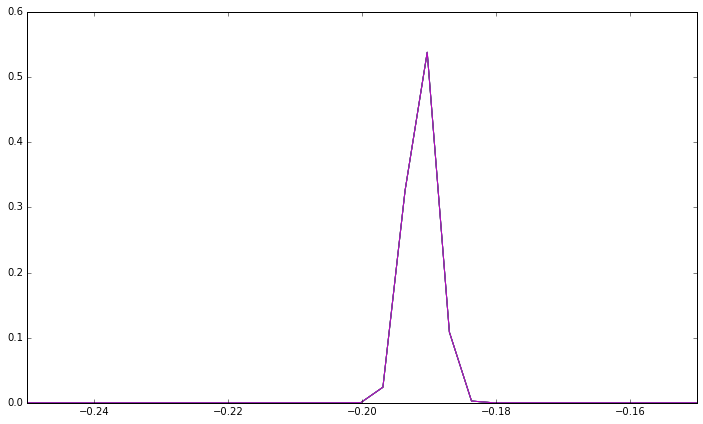

In [212]:
for cat in ['Bunker']:#course_profiles[course_profiles.keys()[0]]:
    plt.figure(figsize=(12,7))
    for course in course_profiles.keys()[20:25]:
        print np.dot(course_profiles[course][cat][0],course_profiles[course][cat][1])
        plt.plot(course_profiles[course][cat][0],course_profiles[course][cat][1]);
    plt.xlim(-.25,-.15)
    plt.show()